# Model v1 training
Training notebook with windsat dataset

In [1]:
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess
from src.model import create_training_df, xy_split, plot_history

In [2]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Preprocess and select the dataset
ascds = model_preprocess(ds,swath_sector=0, look="impute", add_look_flag= False)
ascds


<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# Create a dataframe for the model training
ascds_df = create_training_df(ascds)
ascds_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H
212694,275.894440,-0.799947,0.959437,194.885010,127.485001,215.657501,163.107498
217918,286.504700,-0.789352,-0.869279,227.401212,181.193552,238.102593,198.956897
217921,285.798737,-0.789352,-0.862734,227.867810,181.056147,238.909144,199.383066
219360,285.345428,-0.786666,-0.864933,240.689287,204.720185,249.305659,219.538950
219362,285.551025,-0.786666,-0.860520,241.939255,208.209954,250.099881,221.251201
...,...,...,...,...,...,...,...
24771688,279.382294,0.943368,0.376629,198.187500,130.512497,208.532501,153.035004
24771689,279.180969,0.943368,0.380667,204.407501,142.735001,210.417496,160.252502
24771690,278.574554,0.943368,0.384698,208.712494,151.412506,212.059998,165.992493
24771691,276.485809,0.943368,0.388722,210.847504,155.565002,212.977493,169.082489


In [9]:
# Define a custom model to train:
def build_model(n_vars):
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(60,activation="linear", name = "hiddenLayer1"),
        Dense(30,activation="relu", name = "hiddenLayer2"),
        Dense(15,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate = 0.014570815050621676 ),
        loss ="mse",
        metrics = ["mse"]
    )

    model.summary()

    return model

n_vars = ascds_df.shape[1] - 1


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755 (10.76 KB)

 Trainable params: 2,743 (10.71 KB)

 Non-trainable params: 12 (48.00 B)

In [12]:
# Pick the columns for training and test
X, y = xy_split(ascds_df)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

model =build_model(n_vars)


# Fit the model
callback = EarlyStopping(
    monitor = "loss",
    patience = 30,
    min_delta = 0.05,
    verbose=2,
    restore_best_weights = True
)

checkpoints = ModelCheckpoint(
    filepath="../../models/checkpoint.weights.h5",
    save_weights_only= True,
    verbose = 1
)

history = model.fit(
    x_train,
    y_train,
    epochs=300,
    batch_size = 512,
    validation_data=(x_test,y_test),
    callbacks=[callback, checkpoints],
    verbose = 1,
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755 (10.76 KB)

 Trainable params: 2,743 (10.71 KB)

 Non-trainable params: 12 (48.00 B)

Epoch 1/300
2266/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3970.8262 - mse: 3970.8262
Epoch 1: saving model to ../../models/checkpoint.weights.h5
2291/2291 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3934.0427 - mse: 3934.0427 - val_loss: 20.7545 - val_mse: 20.7545
Epoch 2/300
2237/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.4071 - mse: 22.4071
Epoch 2: saving model to ../../models/checkpoint.weights.h5
2291/2291 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 22.4094 - mse: 22.4094 - val_loss: 16.6618 - val_mse: 16.6618
Epoch 3/300
2281/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.4506 - mse: 21.4506
Epoch 3: saving model to ../../models/checkpoint.weights.h5
2291/2291 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 21.4432 - mse: 21.4432 - val_loss: 18.1854 - val_mse: 18.1854
Epoch 4/300
2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3233 - mse: 17.3233
Epoch 4: saving model to ../../models/checkpoint.weights.h5
2291/2291 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 17.3235 - mse: 17.

In [13]:
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")
print(now)

# Save FINAL model weights and history data.
model_path = f"../../models/{now}.keras"
save_model(model, model_path)

# Save training history
history_path = f"../../models/{now}_history"
with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)


2024_07_19T130114


(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 50'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

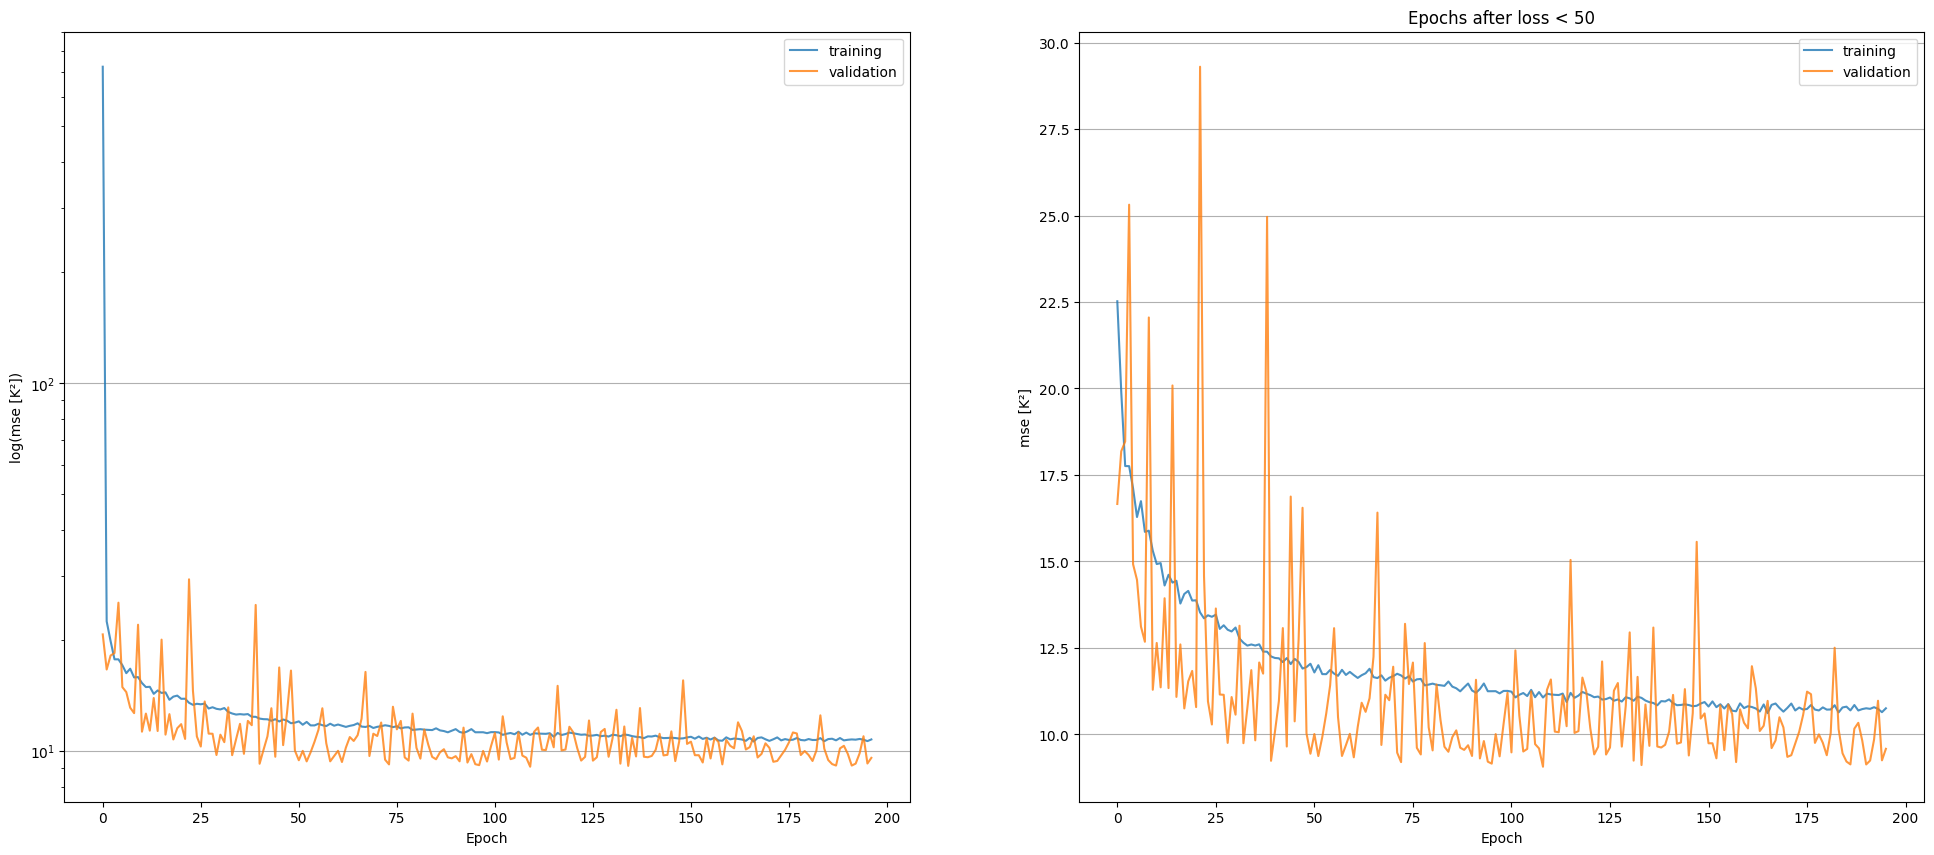

In [15]:
# Check the loading of the history file works
with open(history_path,"rb") as hfile:
    history = pickle.load(hfile)
    
plot_history(history,loss_threshold=50)